In [1]:
using DataFrames, CSV, DelimitedFiles, Plots, FFTW
include("/home/kirk/Documents/research/CHANDRATest/DJM.jl")

┌ Info: Recompiling stale cache file /home/kirk/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184


Main.DJM

In [2]:
function pdot(f) #change in period due to accretion, serious estimating involved
    Pdot2 = -2  #seconds/year
    Pdot1 = -5
    P1 = 0
    P2 = 3
    plog=log10(1/f)

    dpdot = (Pdot2 - Pdot1)/(P2-P1)
    logpdot = Pdot1 + (plog-P1)*dpdot
    return(10^logpdot)
end

pdot (generic function with 1 method)

In [12]:
using Formatting
#Note: running this function for pows8 took ~2.5min on my laptop
function createPowMatrixOVERLAP(powList)
    n=ceil(maximum(powList.power[:]))
    df=0.0001
    nk=ceil(maximum(powList.freq[:])/df)
    powMatrix=zeros(101,101,Int(nk)+1) #any power greater than 100 will go in 101,nk for freq z direction, +1 because 1 is for normal matrix
    justPow=powList.power[:]
    errorCount=0
    counter=0
    for i in 1:length(justPow)
        print(format(i/length(justPow)*100,precision=2),"% complete\r") #output % tracker
        if ceil(powList.power[i])>100
            currentRow=101 #power is too big
        else
            currentRow=ceil(powList.power[i]) #row index for use later
        end
        
        for j in (i+1):length(justPow) #i+1 accounts for indistinguishability
            counter+=1
            if ceil(powList.power[j])>100
                currentCol=101 #other power too big
            else
               currentCol=ceil(powList.power[j]) #column index for use later
            end
            try #need to use try statement because gcdist breaks sometimes?
                rdist = DJM.gcdist(powList.ra[j],powList.dec[j],powList.ra[i],powList.dec[i])
                if (rdist*60.0 < 0.01666) #MODIFIED NOW IN THE SAME PLACE
                    powMatrix[Int(currentRow),Int(currentCol),1]+=1 #found a pair, doesn't account for overcounting (indistinguishability)
                    #stuff below for freq z part of matrix
                    fAvg=(powList.freq[i]+powList.freq[j])/2
                    fAvgDot=1/pdot(fAvg)
                    dt=abs(powList.exptime[i]-powList.exptime[j]) #is exptime the timestamp?
                    fRangeMax=fAvgDot*dt
                    fRangeMin=fAvgDot*(-dt)
                        if fAvg>=fRangeMin && fAvg<=fRangeMax
                            kInd=ceil(fAvg/df)                                
                            #println(kInd," successfully appended to k index") note: it does work!
                            powMatrix[Int(currentRow),Int(currentCol),Int(kInd+1)]+=1 #kInd+1 because 1 is base matrix
                        end
                end
            catch
                errorCount+=1 #this error is because it tries to take acos of #>1 (I think) in gcdist
                              #maybe because of rounding errors?
            end
        end
    end
    println(errorCount," total errors accumulated")
    println(errorCount/counter*100,"% error")
    return powMatrix
end

function createPowMatrix(powList)
    n=ceil(maximum(powList.power[:]))
    df=0.0001
    nk=ceil(maximum(powList.freq[:])/df)
    powMatrix=zeros(101,101,Int(nk)+1) #any power greater than 100 will go in 101,nk for freq z direction, +1 because 1 is for normal matrix
    justPow=powList.power[:]
    errorCount=0
    counter=0
    for i in 1:length(justPow)
        print(format(i/length(justPow)*100,precision=2),"% complete\r") #output % tracker
        if ceil(powList.power[i])>100
            currentRow=101 #power is too big
        else
            currentRow=ceil(powList.power[i]) #row index for use later
        end
        
        for j in (i+1):length(justPow) #i+1 accounts for indistinguishability
            counter+=1
            if ceil(powList.power[j])>100
                currentCol=101 #other power too big
            else
               currentCol=ceil(powList.power[j]) #column index for use later
            end
            try #need to use try statement because gcdist breaks sometimes?
                rdist = DJM.gcdist(powList.ra[j],powList.dec[j],powList.ra[i],powList.dec[i])
                if (rdist*60.0 > 0.01666) #not in the same place
                    powMatrix[Int(currentRow),Int(currentCol),1]+=1 #found a pair, doesn't account for overcounting (indistinguishability)
                    #stuff below for freq z part of matrix
                    fAvg=(powList.freq[i]+powList.freq[j])/2
                    fAvgDot=1/pdot(fAvg)
                    dt=abs(powList.exptime[i]-powList.exptime[j]) #is exptime the timestamp?
                    fRangeMax=fAvgDot*dt
                    fRangeMin=fAvgDot*(-dt)
                        if fAvg>=fRangeMin && fAvg<=fRangeMax
                            kInd=ceil(fAvg/df)                                
                            #println(kInd," successfully appended to k index") note: it does work!
                            powMatrix[Int(currentRow),Int(currentCol),Int(kInd+1)]+=1 #kInd+1 because 1 is base matrix
                        end
                end
            catch
                errorCount+=1 #this error is because it tries to take acos of #>1 (I think) in gcdist
                              #maybe because of rounding errors?
            end
        end
    end
    println(errorCount," total errors accumulated")
    println(errorCount/counter*100,"% error")
    return powMatrix
end

createPowMatrix (generic function with 1 method)

In [4]:
function genFreqSums(powMatrix)
    sums=zeros(length(powMatrix[1,1,2:end]))
    for i in 1:length(powMatrix[1,1,2:end])
        sums[i]+=sum(powMatrix[:,:,i+1]) #i+1 becaus normal matrix is in 1st slice
    end
    return sums
end
function sumsLog(sums)
    sums4log=zeros(length(sums))
    for i in 1:length(sums4log)
        if sums[i]==0
            sums4log[i]=1
        else
            sums4log[i]=sums[i]
        end
    end
    return sums4log
end
function genFRange(df,powList)
    fbins=ceil(maximum(powList.freq[:])/df)
    frange=zeros(Int(fbins))
    for i in 1:length(frange)
        frange[i]=i*df
    end
    return frange
end

genFRange (generic function with 1 method)

In [13]:
pows8=CSV.read("cxc.fftinfo.all8")
pows8MatrixOVERLAP=createPowMatrixOVERLAP(pows8)
sums8OVERLAP=genFreqSums(pows8MatrixOVERLAP)
sums8LogOVERLAP=sumsLog(sums8OVERLAP)

pows8=CSV.read("cxc.fftinfo.all8")
pows8Matrix=createPowMatrix(pows8)
sums8=genFreqSums(pows8Matrix)
sums8Log=sumsLog(sums8)

0 total errors accumulated
0.0% error


31.83

0 total errors accumulated complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% complete% com

1546-element Array{Float64,1}:
 208225.0
 198709.0
  98275.0
  54667.0
  57434.0
 226288.0
 111350.0
 152671.0
  87963.0
  51038.0
  72288.0
  46040.0
  60017.0
      ⋮  
    610.0
    737.0
    849.0
    665.0
    520.0
    196.0
    172.0
    184.0
    157.0
     90.0
     25.0
      1.0

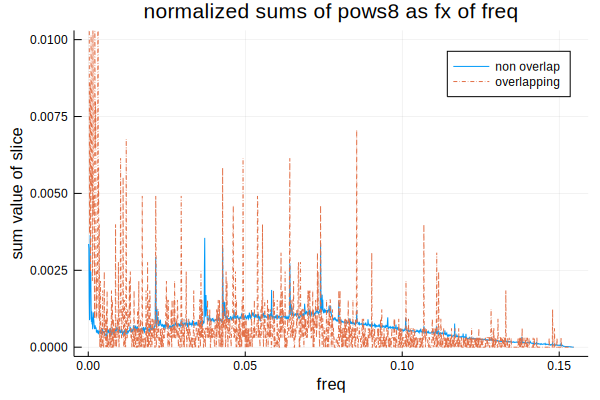

In [21]:
fRange8=genFRange(0.0001,pows8)
plot(fRange8,sums8./sum(sums8),title="normalized sums of pows8 as fx of freq",xlabel="freq",ylabel="sum value of slice",label="non overlap")
plot!(fRange8,sums8OVERLAP./sum(sums8OVERLAP),label="overlapping",linestyle=:dashdot,ylims=[0,0.01])

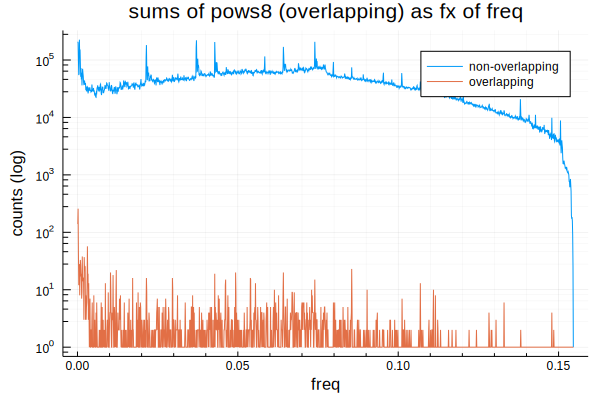

In [15]:
plot(fRange8,sums8Log,yaxis=:log,title="sums of pows8 (overlapping) as fx of freq",xlabel="freq",ylabel="counts (log)",label="non-overlapping",minorticks=true,minorgrid=true)
plot!(fRange8,sums8LogOVERLAP,label="overlapping")

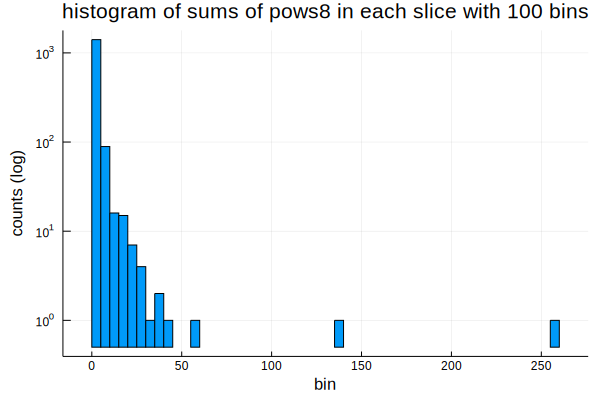

In [9]:
histogram(sums8,bins=100,yaxis=:log,title="histogram of sums of pows8 in each slice with 100 bins",xlabel="bin",ylabel="counts (log)",label="")